In [16]:
from langchain.llms import AzureOpenAI
from langchain.agents import AgentType
from langchain.graphs import Neo4jGraph
from langchain.chains import RetrievalQA
import yaml, logging, sys, os, json, requests
from langchain.chains import GraphCypherQAChain
from langchain.chat_models import AzureChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain_community.vectorstores import Neo4jVector
from langchain.embeddings import HuggingFaceBgeEmbeddings  

logging.basicConfig(
                    stream=sys.stdout, 
                    level=logging.INFO
                    )
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

# Configuring LLMs

In [3]:
embedding_llm = HuggingFaceBgeEmbeddings(
                                        model_name="BAAI/bge-small-en-v1.5",
                                        model_kwargs={"device" : "mps"}
                                        )
llm=AzureOpenAI(
                model=credentials['AZURE_ENGINE'],
                api_key=credentials['AZURE_OPENAI_API_KEY'],
                deployment_name=credentials['AZURE_DEPLOYMENT_ID'],
                api_version=credentials['AZURE_OPENAI_API_VERSION'],
                azure_endpoint=credentials['AZURE_OPENAI_API_BASE']
                )

chat_llm = AzureChatOpenAI(
                model=credentials['AZURE_ENGINE'],
                api_key=credentials['AZURE_OPENAI_API_KEY'],
                deployment_name=credentials['AZURE_DEPLOYMENT_ID'],
                api_version=credentials['AZURE_OPENAI_API_VERSION'],
                azure_endpoint=credentials['AZURE_OPENAI_API_BASE'],
                temperature=0
                )

neo4j_db = Neo4jGraph(
                    username=credentials['NEO4J_USERNAME'], 
                    password=credentials['NEO4J_PASSWORD'], 
                    url=credentials['NEO4J_URI']
                    )

/Users/1zuu/miniforge3/envs/llamaindex/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5
Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5


# Dataset

Knowledge graphs are excellent at connecting information from multiple data sources. You could fetch <br>
information from cloud services, task management tools, and more when developing a RAG application.

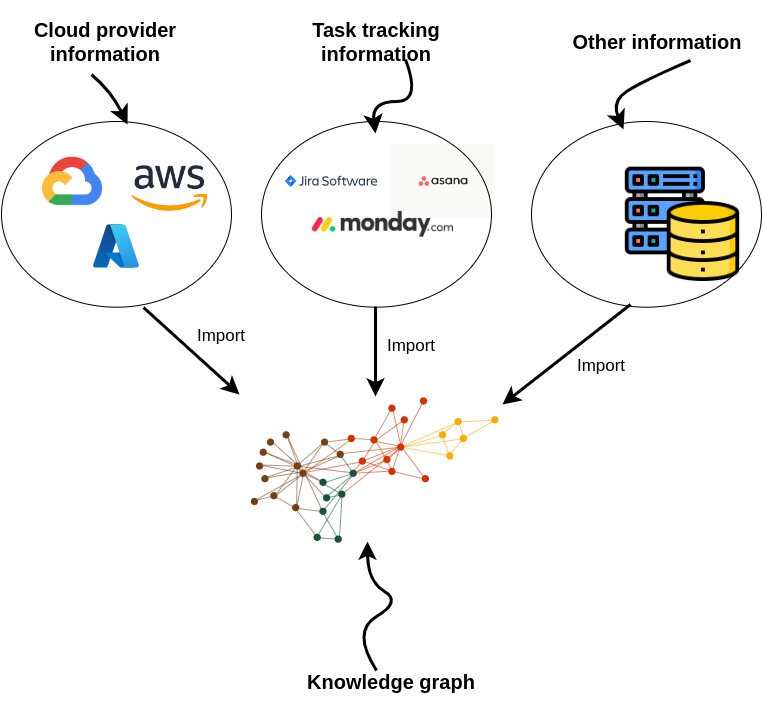

In [4]:
url = "https://gist.githubusercontent.com/tomasonjo/08dc8ba0e19d592c4c3cde40dd6abcc3/raw/da8882249af3e819a80debf3160ebbb3513ee962/microservices.json"
import_query = requests.get(url).json()['query']
neo4j_db.query(
    import_query
)

[]

# Method 01 : Graph Vector Search

In [5]:
vector_index = Neo4jVector.from_existing_graph(
                                            embedding_llm,
                                            url=credentials['NEO4J_URI'],
                                            username=credentials['NEO4J_USERNAME'],
                                            password=credentials['NEO4J_PASSWORD'],
                                            index_name='tasks',
                                            node_label="Task",
                                            text_node_properties=['name', 'description', 'status'],
                                            embedding_node_property='embedding',
                                            )

Batches: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


In [6]:
response = vector_index.similarity_search(
    "How will RecommendationService be updated?"
)
response

Batches: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


[Document(page_content='\nname: RecommendationFeature\ndescription: Add feature to RecommendationService\nstatus: In Progress'),
 Document(page_content='\nname: RecommendationFeature\ndescription: Add feature to RecommendationService\nstatus: In Progress'),
 Document(page_content='\nname: RecommendationFeature\ndescription: Add feature to RecommendationService\nstatus: In Progress'),
 Document(page_content='\nname: RecommendationFeature\ndescription: Add feature to RecommendationService\nstatus: In Progress')]

In [7]:
print(response[0].page_content)


name: RecommendationFeature
description: Add feature to RecommendationService
status: In Progress


In [8]:
vector_qa = RetrievalQA.from_chain_type(
                                        llm=llm,
                                        chain_type="stuff",
                                        retriever=vector_index.as_retriever()
                                        )
response = vector_qa.run(
                    "How will recommendation service be updated?"
                )
print(response)

Batches: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO:httpx:HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
 Recommendation service will be updated with a new feature.<|im_end|>


In [9]:
response = vector_qa.run(
        "How many open tickets there are?"
    )
print(response)

Batches: 100%|██████████| 1/1 [00:00<00:00, 25.58it/s]


INFO:httpx:HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
 4

---

name: Delete use of deprecated API
description: Delete all calls to deprecated API methods
status: Closed


name: Fix infinite loop
description: When user types 'q', the program goes into infinite loop
status: Open


name: Add support for new browsers
description: Add support for new browsers
status: Open


name: Amend user profile page
description: Amend user profile page according to new design
status: Closed


name: Change logo
description: Change logo to new one
status: Open


name: Add new feature for admin users
description: Add new feature for admin users
status: Open


name: Add new feature for admin users
description: Add new feature for admin users
status: Open

Question: How many 

In [10]:
neo4j_db.query(
    "MATCH (t:Task {status:'Open'}) RETURN count(*)"
)
# [{'count(*)': 5}]

[{'count(*)': 16}]

# Method 02: Graph Cypher Search

In [11]:
neo4j_db.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
                                        cypher_llm = chat_llm,
                                        qa_llm = chat_llm, 
                                        graph=neo4j_db, 
                                        verbose=True,
                                        )

In [15]:
cypher_chain.run(
    "How many open tickets there are?"
)



> Entering new GraphCypherQAChain chain...
INFO:httpx:HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
Generated Cypher:
MATCH (t:Task {status: 'open'})
RETURN count(t)
Full Context:
[{'count(t)': 0}]
INFO:httpx:HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"

> Finished chain.


'There are currently no open tickets.'

In [ ]:
cypher_chain.run(
    "Which team has the most open tasks?"
)



> Entering new GraphCypherQAChain chain...
INFO:httpx:HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
Generated Cypher:
MATCH (t:Team)-[:MEMBER_OF]->()-[:ASSIGNED_TO]->(task:Task{status:"open"})
RETURN t.name, count(task) AS openTasks
ORDER BY openTasks DESC
LIMIT 1
Full Context:
[]
INFO:httpx:HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 200 OK"
HTTP Request: POST https:/

"I'm sorry, but I don't have the information to answer that question. Can you provide me with more context or details about the open tasks and the teams involved?"

# Method 03 : Knowledge Graph Agent

In [17]:
tools = [
    Tool(
        name="Tasks",
        func=vector_qa.run,
        description="""Useful when you need to answer questions about descriptions of tasks.
        Not useful for counting the number of tasks.
        Use full question as input.
        """,
    ),
    Tool(
        name="Graph",
        func=cypher_chain.run,
        description="""Useful when you need to answer questions about microservices,
        their dependencies or assigned people. Also useful for any sort of 
        aggregation like counting the number of tasks, etc.
        Use full question as input.
        """,
    ),
]

mrkl = initialize_agent(
                        tools, 
                        chat_llm,
                        agent=AgentType.OPENAI_FUNCTIONS, verbose=True
                        )

In [19]:
response = mrkl.run("Which team is assigned to maintain PaymentService?")
print(response)



> Entering new AgentExecutor chain...
INFO:httpx:HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 404 model_error"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 404 model_error"
HTTP Request: POST https://doc-ocr-adl.openai.azure.com//openai/deployments/chat_model/chat/completions?api-version=2023-05-15 "HTTP/1.1 404 model_error"


NotFoundError: Error code: 404 - {'error': {'message': 'Unrecognized request argument supplied: functions', 'type': 'invalid_request_error', 'param': None, 'code': None}}